# Extract Values from a classified image service layer
This notebook demonstrates how to filter an ImageryLayer by time and extract stats for an area. 

## Workflow
* Import packages
* Import the ImageryService
* Extract and display properties of the ImageryService
* Create the shape to query
* Filter the imagery service on shape, time, and other criteria
* Create histograms
    * Convert to dataframe
    * Save
    * Plot


#### Import packages

In [1]:
#Import packages
from arcgis import GIS
from arcgis.raster import ImageryLayer, Raster
from arcgis.geometry import Point, filters, Polygon
from datetime import datetime
import pandas as pd

#Connect to the GIS
gis = GIS("pro")

#### Create a table of NLCD Classes
In the folder is a CSV file listing NLCD class values and their corresponding class names. We'll use this to convert the raw pixel values to know class types. 

Note: I generated the NLCD.csv by using Perplexity AI with the prompt: ["Generate CSV format text of NLCD class values and names"](https://www.perplexity.ai/search/generate-csv-format-text-of-nl-AcOf927bQdemiEB_FXGB.Q), then copied and pasted the results into a new text file. 

In [2]:
#Fetch the NLCD land cover classes
df_classes = pd.read_csv(
    'https://raw.githubusercontent.com/ENV859/ArcGIS-PythonAPI/refs/heads/master/data/NLCD.csv',
     index_col=0)
df_classes.head(3)

,Class Name
Value,
11,Open Water
12,Perennial Ice/Snow
21,Developed Open Space


#### Generate some geometries used to query the imagery layer

In [3]:
#Start by setting the coordinate of our point
lat = 36
lng = -78.9

#Create a point, using the lat and lng coordinates and the spatial reference of WGS84
the_point = Point({
    "x" : lng, 
    "y" : lat, 
    "spatialReference" : {"wkid" : 4326}
    })

#Create a buffer around the point
the_buffer = the_point.buffer(1000)

#Create a polygon
the_polygon = Polygon({
    "rings" : [[
        [lng-0.2, lat-0.2], 
        [lng+0.2, lat-0.2], 
        [lng+0.2, lat+0.2], 
        [lng-0.2, lat+0.2], 
        [lng-0.2, lat-0.2]]],
    "spatialReference" : {"wkid" : 4326}
    })

#Show the type of our point
type(the_point), type(the_polygon)

(arcgis.geometry._types.Point, arcgis.geometry._types.Polygon)

#### Fetch the NLCD ImageryLayer
* Navigate to the [Living Atlas](https://livingatlas.arcgis.com) and search for NCLD, select the [`USA NLCD Land Cover`](https://dukeuniv.maps.arcgis.com/home/item.html?id=3ccf118ed80748909eb85c6d262b426f) service. 
* Examine the properties of the service.
    * Note this imagery layer is served as a **time series** meaning the service includes multiple versions of the data representing different times.
    * The layer also has different **processing templates**; we'll examine those later.
* Select the service URL in the lower right side of the page; we'll use that to fetch the imagery layer. 
    * Note that when fetching the layer with the `ImageryLayer()` command, we need to supply the "gis" object. That is because this is a subscription only dataset, and to access it, we need to provide our authenticated link to ArcGIS Online, created when we created our "gis" object in the first code cell. 

In [4]:
#Set the service URL
service_url = "https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover/ImageServer"

#Fetch the service at the URL
nlcd_layer = ImageryLayer(service_url, gis=gis)

#Display the type of the layer
type(nlcd_layer)

arcgis.raster._layer.ImageryLayer

#### Explore the imagery layer
With the imagery layer imported into our coding environment, let's now examine some important properties. First we'll extract the feature set associated with this ImageryLayer object, done with the `query()` function, and then we'll convert this feature set to a spatial dataframe (sdf) so we can examine its contents. 

>►The feature set associated with an imagery layer includes information and spatial extents of the individual images contained in the ImageryLayer service. 

In [5]:
#Extract the feature set associated with the ImageryLayer
nlcd_featureSet = nlcd_layer.query()

#Convert to a spatial dataframe, setting the OBJECTID as the index
nlcd_sdf = nlcd_featureSet.sdf.set_index("OBJECTID")

#Display the first three rows of the dataframe
nlcd_sdf.head()

,Name,MinPS,MaxPS,LowPS,HighPS,Category,Tag,GroupName,ProductName,CenterX,CenterY,ZOrder,Shape_Length,Shape_Area,StartYear,EndYear,SHAPE
OBJECTID,,,,,,,,,,,,,,,,,
45,USA_NLCD_Land_Cover_2016_conus_trailing,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2018,16005180.0,15544534951800.009766,2017,2018,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
46,USA_NLCD_Land_Cover_2016_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2016,16005180.0,15544534951800.009766,2016,2016,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
47,USA_NLCD_Land_Cover_2013_conus_trailing,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2015,16005180.0,15544534951800.009766,2014,2015,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
48,USA_NLCD_Land_Cover_2013_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2013,16005180.0,15544534951800.009766,2013,2013,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
49,USA_NLCD_Land_Cover_2011_conus_trailing,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2012,16005180.0,15544534951800.009766,2012,2012,"{""rings"": [[[-2399031.576199999, -1802272.9335..."


#### Selecting images from the ImageryLayer for use in analysis
In the above dataframe, each row represents an image that we analyze, and each column represents an attribute we can use to subset the images used in our analysis. We can also subset rows by filtering for those that intersect a specified *geometry* or that include a specified *time* or *time extent*. 

These criteria can be applied in a number of analytical functions associated with [ImageryLayer objects](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer). For example: 
* [`identify()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.identify)
* [`filter_by()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.filter_by)
* [`compute_histograms()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.compute_histograms)
* [`get_samples()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.get_samples)


In [7]:
#Explore the unique dataset names in the imagery layer
list(nlcd_sdf['Name'].unique())

['USA_NLCD_Land_Cover_2016_conus_trailing',
 'USA_NLCD_Land_Cover_2016_conus',
 'USA_NLCD_Land_Cover_2013_conus_trailing',
 'USA_NLCD_Land_Cover_2013_conus',
 'USA_NLCD_Land_Cover_2011_conus_trailing',
 'USA_NLCD_Land_Cover_2011_conus',
 'USA_NLCD_Land_Cover_2011_AK_trailing',
 'USA_NLCD_Land_Cover_2011_AK',
 'USA_NLCD_Land_Cover_2008_conus_trailing',
 'USA_NLCD_Land_Cover_2008_conus',
 'USA_NLCD_Land_Cover_2006_conus_trailing',
 'USA_NLCD_Land_Cover_2006_conus',
 'USA_NLCD_Land_Cover_2005_HI_trailing',
 'USA_NLCD_Land_Cover_2005_HI',
 'USA_NLCD_Land_Cover_2004_conus_trailing',
 'USA_NLCD_Land_Cover_2004_conus',
 'USA_NLCD_Land_Cover_2001_PR_trailing',
 'USA_NLCD_Land_Cover_2001_PR',
 'USA_NLCD_Land_Cover_2001_HI_trailing',
 'USA_NLCD_Land_Cover_2001_HI',
 'USA_NLCD_Land_Cover_2001_conus_trailing',
 'USA_NLCD_Land_Cover_2001_conus',
 'USA_NLCD_Land_Cover_2001_AK_trailing',
 'USA_NLCD_Land_Cover_2001_AK',
 'USA_NLCD_Land_Cover_2011_HI',
 'USA_NLCD_Land_Cover_2011_HI_trailing',
 'USA_NLC

##### Using `filter_by` to create a subset of images
* To filter images using attributes in the feature set dataframe, we use the `where` parameter, supplying a valid "where clause"
* To filter images using a time/time extent, we use the `time` parameter, supplying datetime objects
* To filter images using location, we use the `geometry` parmameter, supplying arcgis geometry objects 

In [8]:
#Query the imagery layer
selected_images = nlcd_layer.filter_by(
    #where="Name = 'USA_NLCD_Land_Cover_2016_conus'",  #Filter for just USA_NLCD_Land_Cover_2016_conus
    where = "Name LIKE 'USA_NLCD_Land_Cover_%_conus'", #Filter for all records with the name 'USA_NLCD_Land_Cover_????_conus' (where ???? is a wildcard)
    #time=[datetime(2016,1,1), datetime(2016,12,31)],  #Filter for datasets collected in 2016
    geometry=filters.intersects(the_point),            #Filter for datasets that intersect the point
)

#Show the selected images as a dataframe
selected_images_df = selected_images.query(out_fields="*").sdf
selected_images_df

,OBJECTID,Name,MinPS,MaxPS,LowPS,HighPS,Category,Tag,GroupName,ProductName,CenterX,CenterY,ZOrder,Shape_Length,Shape_Area,StartYear,EndYear,SHAPE
0,46,USA_NLCD_Land_Cover_2016_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2016,16005180.0,15544534951800.009766,2016,2016,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
1,48,USA_NLCD_Land_Cover_2013_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2013,16005180.0,15544534951800.009766,2013,2013,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
2,50,USA_NLCD_Land_Cover_2011_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2011,16005180.0,15544534951800.009766,2011,2011,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
3,54,USA_NLCD_Land_Cover_2008_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2008,16005180.0,15544534951800.009766,2008,2008,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
4,56,USA_NLCD_Land_Cover_2006_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2006,16005180.0,15544534951800.009766,2006,2006,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
5,60,USA_NLCD_Land_Cover_2004_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2004,16005180.0,15544534951800.009766,2004,2004,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
6,66,USA_NLCD_Land_Cover_2001_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2001,16005180.0,15544534951800.009766,2001,2001,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
7,74,USA_NLCD_Land_Cover_2019_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2019,16005180.0,15544534951800.009766,2019,2019,"{""rings"": [[[-2399031.576199999, -1802272.9335..."
8,75,USA_NLCD_Land_Cover_2021_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2021,16005180.0,15544534951800.009766,2021,2021,"{""rings"": [[[-2399031.576199999, -1802272.9335..."


#### Extract values at a specific location using `identify()`
The `identify()` tool queries the imagery layer at a specific location that we provide. If we provide anything but a single point, results are generated for the centroid of the geometry provided.  
Results are provided in the form of a dictionary from which we can extract values. 

In [9]:
#Use identify to get the value at the point or centroid of non-point geometry
pt_results = selected_images.identify(
    geometry=the_point
)
pt_results

{'objectId': 0,
 'name': 'Pixel',
 'value': '23',
 'location': {'x': 1451462.2027476805,
  'y': -339261.99780684616,
  'spatialReference': {'wkid': 102008, 'latestWkid': 102008}},
 'properties': {'Values': ['23',
   '23',
   '23',
   '23',
   '23',
   '23',
   '23',
   '23',
   '23']},
 'catalogItems': {'objectIdFieldName': 'OBJECTID',
  'features': [{'attributes': {'OBJECTID': 46,
     'Name': 'USA_NLCD_Land_Cover_2016_conus',
     'MinPS': 0,
     'MaxPS': 1728000,
     'LowPS': 30,
     'HighPS': 172800,
     'Category': 1,
     'Tag': 'Dataset',
     'GroupName': '',
     'ProductName': '',
     'CenterX': -73112.27589999977,
     'CenterY': -142882.9334999998,
     'ZOrder': 2016,
     'Shape_Length': 16005180.000000006,
     'Shape_Area': 15544534951800.01,
     'StartYear': '2016',
     'EndYear': '2016'}},
   {'attributes': {'OBJECTID': 48,
     'Name': 'USA_NLCD_Land_Cover_2013_conus',
     'MinPS': 0,
     'MaxPS': 1728000,
     'LowPS': 30,
     'HighPS': 172800,
     'Categ

In [10]:
#Extract a list of the values at the point
values = pt_results['properties']['Values']

#Add to our dataframe of images
selected_images_df['ClassValue'] = values

In [11]:
selected_images_df['ClassValue'] = values
selected_images_df

,OBJECTID,Name,MinPS,MaxPS,LowPS,HighPS,Category,Tag,GroupName,ProductName,CenterX,CenterY,ZOrder,Shape_Length,Shape_Area,StartYear,EndYear,SHAPE,ClassValue
0,46,USA_NLCD_Land_Cover_2016_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2016,16005180.0,15544534951800.009766,2016,2016,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
1,48,USA_NLCD_Land_Cover_2013_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2013,16005180.0,15544534951800.009766,2013,2013,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
2,50,USA_NLCD_Land_Cover_2011_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2011,16005180.0,15544534951800.009766,2011,2011,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
3,54,USA_NLCD_Land_Cover_2008_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2008,16005180.0,15544534951800.009766,2008,2008,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
4,56,USA_NLCD_Land_Cover_2006_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2006,16005180.0,15544534951800.009766,2006,2006,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
5,60,USA_NLCD_Land_Cover_2004_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2004,16005180.0,15544534951800.009766,2004,2004,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
6,66,USA_NLCD_Land_Cover_2001_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2001,16005180.0,15544534951800.009766,2001,2001,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
7,74,USA_NLCD_Land_Cover_2019_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2019,16005180.0,15544534951800.009766,2019,2019,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23
8,75,USA_NLCD_Land_Cover_2021_conus,0.0,1728000.0,30.0,172800.0,1,Dataset,,,-73112.2759,-142882.9335,2021,16005180.0,15544534951800.009766,2021,2021,"{""rings"": [[[-2399031.576199999, -1802272.9335...",23


In [12]:
#Look up the pixel value from the NLCD land cover classes
pixel_value = pt_results['value']
the_class = df_classes.loc[int(pixel_value)].values[0]
print(f"The pixel value at lat:{the_point.coordinates()[1]}, lng:{the_point.coordinates()[0]} is {the_class}")

The pixel value at lat:36.0, lng:-78.9 is Developed Medium Intensity


#### Extract values within an area
The `compute_histograms()` function allows us to extract the number of pixels in each class falling within a geometry we specify. 

In [13]:
the_hist = nlcd_layer.compute_histograms(
    geometry=the_point.buffer(0.2),
    time=[datetime(2006,1,1), datetime(2006,12,31)]
)

The result is a dictionary, from which we can extract values into a dataframe

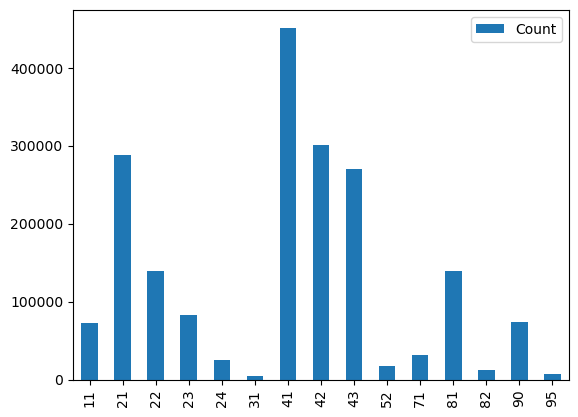

In [20]:
#Extract the counts from the first (and only) item associated the histograms key
the_counts = the_hist['histograms'][0]['counts']

#Convert the histogram to a dataframe
df_results = pd.DataFrame(the_counts,columns=['Count'])

#Plot non-zero values
df_results.query("Count > 0").plot(kind='bar');

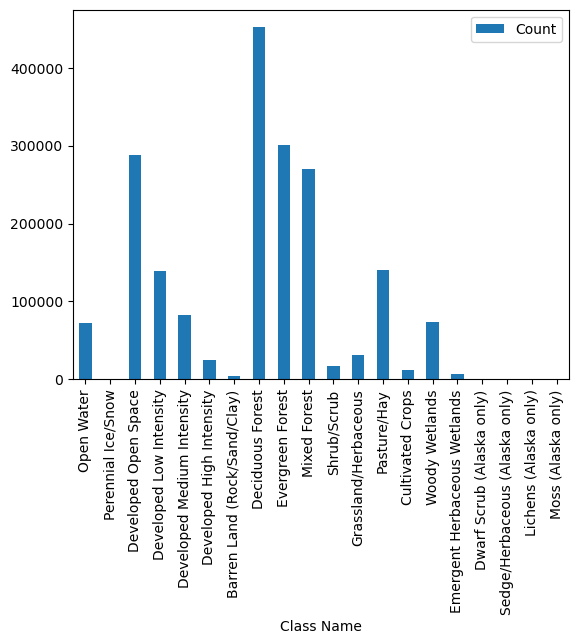

In [23]:
#Merge with the classes DataFrame
df_histo = pd.merge(df_classes, df_results, left_index=True, right_index=True)
df_histo.plot.bar(x='Class Name', y='Count');